# V-JEPA 2

V-JEPA 2 is a new open 1.2B video embedding model by Meta, which attempts to capture the physical world modelling through video ⏯️

The model can be used for various tasks for video: fine-tuning for downstream tasks like video classification, or any task involving embeddings (similarity, retrieval and more!).

You can check all V-JEPA 2 checkpoints and the datasets that come with this release [in this collection](https://huggingface.co/collections/facebook/v-jepa-2-6841bad8413014e185b497a6).

In this notebook we will go through:
1. Using V-JEPA 2 as feature extractor,
2. Using V-JEPA 2 for video classification
3. fine-tuning V-JEPA 2, on [UCF-101 action recognition dataset](https://huggingface.co/datasets/sayakpaul/ucf101-subset) using transformers.

Let's go!

We need to install accelerate, datasets and transformers' main branch.

In [ ]:
!pip install -U https://github.com/huggingface/transformers

torchcodec 0.2.1 supports Colab, which is supported by different torch and torchvision versions, so let's update them too.

In [ ]:
!pip install -q torch==2.6.0 torchvision==0.21.0
!pip install -q torchcodec==0.2.1

import torch
print("Torch:", torch.__version__)
from torchcodec.decoders import VideoDecoder # validate it works


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 115.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.4/766.4 kB 21.4 MB/s eta 0:00:00
Torch: 2.6.0+cu124


## Simple Inference

**Inference with Embeddings**

You can initialize the V-JEPA 2 with ViT Giant checkpoint as follows. Feel free to replace the ID with the one you want to use. Here's [the model collection](https://huggingface.co/collections/facebook/v-jepa-2-6841bad8413014e185b497a6).

In [ ]:
from transformers import AutoVideoProcessor, AutoModel

model = AutoModel.from_pretrained("facebook/vjepa2-vitg-fpc64-384").to("cuda")
processor = AutoVideoProcessor.from_pretrained("facebook/vjepa2-vitg-fpc64-384")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Simply infer to get the embeddings.

In [ ]:
import torch
from torchcodec.decoders import VideoDecoder
import numpy as np

video_url = "https://huggingface.co/datasets/merve/vlm_test_images/resolve/main/holding_phone.mp4"
vr = VideoDecoder(video_url)
frame_idx = np.arange(0, 32) # choosing some frames. here, you can define more complex sampling strategy
video_frames = vr.get_frames_at(indices=frame_idx).data  # T x C x H x W
video = processor(video_frames, return_tensors="pt").to(model.device)
with torch.no_grad():
    video_embeddings = model.get_vision_features(**video)

print(video_embeddings.shape)
del model


torch.Size([1, 9216, 1408])


**Inference for Video Classification**

Meta also provides a model trained on SomethingSomething-v2, a dataset of human-object interactions with 174 classes.

In [ ]:
from transformers import VJEPA2ForVideoClassification, VJEPA2VideoProcessor

model = VJEPA2ForVideoClassification.from_pretrained("facebook/vjepa2-vitl-fpc16-256-ssv2").to("cuda")
processor = VJEPA2VideoProcessor.from_pretrained("facebook/vjepa2-vitl-fpc16-256-ssv2")

We can pass the same frames to the new processor.

In [ ]:
inputs = processor(video_frames, return_tensors="pt").to(model.device)

with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

Touching (without moving) [part] of [something]


## Data Preprocessing for Fine-tuning

Let's load the dataset first. UCF-101 consists of 101 different actions covering from blowing candles to playing violin. We will use [a smaller subset of UCF-101](https://huggingface.co/datasets/sayakpaul/ucf101-subset).

In [ ]:
from huggingface_hub import hf_hub_download
import tarfile
import pathlib

fpath = hf_hub_download(repo_id="sayakpaul/ucf101-subset", filename="UCF101_subset.tar.gz", repo_type="dataset")

with tarfile.open(fpath) as t:
    t.extractall(".")

dataset_root_path = pathlib.Path("UCF101_subset")
all_video_file_paths = list(dataset_root_path.glob("**/*.avi"))

We gather different splits as lists to later create the `DataLoader` for training.

In [ ]:
train_video_file_paths = []
val_video_file_paths = []
test_video_file_paths = []

for video_file_path in all_video_file_paths:
    video_parts = video_file_path.parts
    if "train" in video_parts:
        train_video_file_paths.append(video_file_path)
    elif "val" in video_parts:
        val_video_file_paths.append(video_file_path)
    elif "test" in video_parts:
        test_video_file_paths.append(video_file_path)
    else:
        raise ValueError(f"Unknown video part: {video_parts}")

video_count_train = len(train_video_file_paths)
video_count_val = len(val_video_file_paths)
video_count_test = len(test_video_file_paths)

video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 405


We need to keep a class label to human-readable label mapping and number of classes to later initialize our model.

In [ ]:
class_labels = {path.parts[2] for path in all_video_file_paths}
label2id = {label: i for i, label in enumerate(class_labels)}
id2label = {i: label for label, i in label2id.items()}

We will create a `CustomVideoDataset` class and initialize our train/test/validation sets for DataLoader.

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchcodec.decoders import VideoDecoder

class CustomVideoDataset(Dataset):
    def __init__(self, video_file_paths, label2id):
        self.video_file_paths = video_file_paths
        self.label2id = label2id

    def __len__(self):
        return len(self.video_file_paths)

    def __getitem__(self, idx):
        video_path = self.video_file_paths[idx]
        label = video_path.parts[2]
        decoder = VideoDecoder(video_path)
        return decoder, self.label2id[label]

train_ds = CustomVideoDataset(train_video_file_paths, label2id)
val_ds = CustomVideoDataset(val_video_file_paths, label2id)
test_ds = CustomVideoDataset(test_video_file_paths, label2id)

V-JEPA 2 is an embedding model. To fine-tune it, we need to load the weights with a randomly initialized task-specific head put on top of them. For this, we can use `VJEPA2ForVideoClassification` class. During the initialization, we should pass in the mapping between the class labels and human readable labels, so the classification head has the same number of classes, and directly outputs human-readable labels with the confidence scores.

On a separate note, if you want to only use embeddings, you can use `AutoModel` to do so. This can be used for e.g. video-to-video retrieval or calculating similarity between videos.


We can now define augmentations and create the data collator. This notebook is made for tutorial purposes, so we keep the augmentations minimal. We can finally initialize the DataLoader afterwards.

In [ ]:
from torchcodec.samplers import clips_at_random_indices
from torchvision.transforms import v2


def collate_fn(
    samples, frames_per_clip, transforms
):
    """Sample clips and apply transforms to a batch."""
    clips, labels = [], []
    for decoder, lbl in samples:
        clip = clips_at_random_indices(
            decoder,
            num_clips=1,
            num_frames_per_clip=frames_per_clip,
            num_indices_between_frames=3,
        ).data
        clips.append(clip)
        labels.append(lbl)

    videos = torch.cat(clips, dim=0)
    videos = transforms(videos)
    return videos, torch.tensor(labels)



train_transforms = v2.Compose([
        v2.RandomResizedCrop((processor.crop_size["height"], processor.crop_size["width"])),
        v2.RandomHorizontalFlip(),
    ])
eval_transforms = v2.Compose([
        v2.CenterCrop((processor.crop_size["height"], processor.crop_size["width"]))
    ])

In [ ]:
from functools import partial

batch_size = 1
num_workers = 8

# DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=partial(collate_fn, frames_per_clip=model.config.frames_per_clip, transforms=train_transforms),
    num_workers=num_workers,
    pin_memory=True,
)
val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=partial(collate_fn, frames_per_clip=model.config.frames_per_clip, transforms=eval_transforms),
    num_workers=num_workers,
    pin_memory=True,
)
test_loader = DataLoader(
    test_ds,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=partial(collate_fn, frames_per_clip=model.config.frames_per_clip, transforms=eval_transforms),
    num_workers=num_workers,
    pin_memory=True,
)

## Model Training

Before training, we will login to HF Hub (to later push the model) and setup tensorboard.

In [ ]:
from huggingface_hub import login
login()

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("runs/vjepa2_finetune")

Here's a small evaluation function we use so we evaluate the model training and log the number to tensorboard.

In [ ]:
def evaluate(
    loader: DataLoader,
    model: VJEPA2ForVideoClassification,
    processor: VJEPA2VideoProcessor,
    device: torch.device,
) -> float:
    """Compute accuracy over a dataset."""
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for vids, labels in loader:
            inputs = processor(vids, return_tensors="pt").to(device)
            labels = labels.to(device)
            logits = model(**inputs).logits
            preds = logits.argmax(-1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total if total > 0 else 0.0

Finally, write the training loop!
- On A100 we can fit in single example, so for better performance we will use gradient accumulation to simulate larger batch sizes.
- We will freeze the backbone completely and only train the head.
- We will use Adam optimizer.
- We need to initialize the model head with the new labels.

In [ ]:
del model
model_name = "qubvel-hf/vjepa2-vitl-fpc16-256-ssv2"
processor = VJEPA2VideoProcessor.from_pretrained(model_name)
model = VJEPA2ForVideoClassification.from_pretrained(
    model_name,
    torch_dtype=torch.float32,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,
).to("cuda")

Some weights of VJEPA2ForVideoClassification were not initialized from the model checkpoint at qubvel-hf/vjepa2-vitl-fpc16-256-ssv2 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([174]) in the checkpoint and torch.Size([10]) in the model instantiated
- classifier.weight: found shape torch.Size([174, 1024]) in the checkpoint and torch.Size([10, 1024]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
gradient_accumulation_steps = 4

for param in model.vjepa2.parameters():
        param.requires_grad = False

# Optimizer and loss
trainable = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(trainable, lr=1e-5)

In [ ]:
# Training loop with gradient accumulation and evaluation
num_epochs = 5
accumulation_steps = 4
for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    optimizer.zero_grad()
    for step, (vids, labels) in enumerate(train_loader, start=1):
        inputs = processor(vids, return_tensors="pt").to(model.device)
        labels = labels.to(model.device)
        outputs = model(**inputs, labels=labels)
        loss = outputs.loss / accumulation_steps
        loss.backward()
        running_loss += loss.item()

        if step % accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()
            print(f"Epoch {epoch} Step {step}: Accumulated Loss = {running_loss:.4f}")
            running_loss = 0.0

    # End of epoch evaluation
    val_acc = evaluate(val_loader, model, processor, model.device)
    print(f"Epoch {epoch} Validation Accuracy: {val_acc:.4f}")
    writer.add_scalar("Val Acc", val_acc, epoch * len(train_loader)) # Log loss



# Final test evaluation
test_acc = evaluate(test_loader, model, processor, model.device)
print(f"Final Test Accuracy: {test_acc:.4f}")
writer.add_scalar("Final Test Acc", test_acc, epoch * len(train_loader) + step) # Log loss
writer.close()


Epoch 1 Step 4: Accumulated Loss = 2.4374
Epoch 1 Step 8: Accumulated Loss = 2.4301
Epoch 1 Step 12: Accumulated Loss = 2.6364
Epoch 1 Step 16: Accumulated Loss = 2.4991
Epoch 1 Step 20: Accumulated Loss = 2.5215
Epoch 1 Step 24: Accumulated Loss = 2.4089
Epoch 1 Step 28: Accumulated Loss = 2.3870
Epoch 1 Step 32: Accumulated Loss = 2.2417
Epoch 1 Step 36: Accumulated Loss = 2.6394
Epoch 1 Step 40: Accumulated Loss = 2.4861
Epoch 1 Step 44: Accumulated Loss = 2.6568
Epoch 1 Step 48: Accumulated Loss = 2.2627
Epoch 1 Step 52: Accumulated Loss = 2.5263
Epoch 1 Step 56: Accumulated Loss = 2.2626
Epoch 1 Step 60: Accumulated Loss = 2.1493
Epoch 1 Step 64: Accumulated Loss = 2.3545
Epoch 1 Step 68: Accumulated Loss = 2.2872
Epoch 1 Step 72: Accumulated Loss = 2.0267
Epoch 1 Step 76: Accumulated Loss = 2.4484
Epoch 1 Step 80: Accumulated Loss = 2.1420
Epoch 1 Step 84: Accumulated Loss = 2.4607
Epoch 1 Step 88: Accumulated Loss = 2.5552
Epoch 1 Step 92: Accumulated Loss = 2.3860
Epoch 1 Step 

Let's push the model and the tensorboard logs to Hub.

In [ ]:
model.push_to_hub("merve/vjepa2-vitl-fpc16-256-ssv2-ucf101")
processor.push_to_hub("merve/vjepa2-vitl-fpc16-256-ssv2-ucf101")

model.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/merve/vjepa2-vitl-fpc16-256-ssv2-ucf101/commit/4da9a6ab7afa6440b18257b361b635c5cf1fa3c5', commit_message='Upload processor', commit_description='', oid='4da9a6ab7afa6440b18257b361b635c5cf1fa3c5', pr_url=None, repo_url=RepoUrl('https://huggingface.co/merve/vjepa2-vitl-fpc16-256-ssv2-ucf101', endpoint='https://huggingface.co', repo_type='model', repo_id='merve/vjepa2-vitl-fpc16-256-ssv2-ucf101'), pr_revision=None, pr_num=None)

In [ ]:
from huggingface_hub import upload_folder
upload_folder(
    repo_id="merve/vjepa2-vitl-fpc16-256-ssv2-ucf101",
    folder_path="runs",
    path_in_repo="runs")

events.out.tfevents.1749828509.38da49c797ee.13694.0:   0%|          | 0.00/371 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/merve/vjepa2-vitl-fpc16-256-ssv2-ucf101/commit/4c0648e3194239a9bebe1dfffff04486d130e2bb', commit_message='Upload folder using huggingface_hub', commit_description='', oid='4c0648e3194239a9bebe1dfffff04486d130e2bb', pr_url=None, repo_url=RepoUrl('https://huggingface.co/merve/vjepa2-vitl-fpc16-256-ssv2-ucf101', endpoint='https://huggingface.co', repo_type='model', repo_id='merve/vjepa2-vitl-fpc16-256-ssv2-ucf101'), pr_revision=None, pr_num=None)

## Evaluation

You can view the logs [here](https://huggingface.co/merve/vjepa2-vitl-fpc16-256-ssv2-ucf101/tensorboard).

Let's put model to test with an in-the-wild video of a concert scene, although we don't exactly have this label, we have "Band Marching" which is the closest one.

In [ ]:
# Utility to plot the frames
# (taken from: https://docs.pytorch.org/torchcodec/stable/generated_examples/basic_example.html#sphx-glr-generated-examples-basic-example-py)
def plot(frames, title, fname):
    try:
        from torchvision.utils import make_grid
        from torchvision.transforms.v2.functional import to_pil_image
        import matplotlib.pyplot as plt
    except ImportError:
        print("Cannot plot, please run `pip install torchvision matplotlib`")
        return

    plt.rcParams["savefig.bbox"] = 'tight'
    _, ax = plt.subplots()
    ax.imshow(to_pil_image(make_grid(frames)))
    ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
    if title is not None:
        ax.set_title(title)
    plt.tight_layout()
    plt.savefig(fname)
    plt.close()



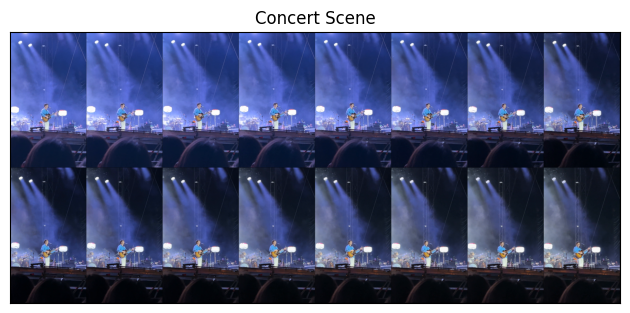

In [ ]:
from PIL import Image
video_url = "https://huggingface.co/datasets/merve/vlm_test_images/resolve/main/IMG_3830.mp4"
vr = VideoDecoder(video_url)
frame_idx = np.arange(0, 32)
video_frames = vr.get_frames_at(indices=frame_idx).data

video = clips_at_random_indices(
    vr,
    num_clips=1,
    num_frames_per_clip=model.config.frames_per_clip,
    num_indices_between_frames=4,
).data

plot(video[0], title="Concert Scene", fname="test.png")
display(Image.open("test.png"))

Closest label is BandMarching so we get this.

In [ ]:
inputs = processor(video_frames, return_tensors="pt").to(model.device)

with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", id2label[predicted_class_idx])

Predicted class: BandMarching


We're looking forward to see what you'll build with V-JEPA 2!